#           Segmenting and Clustering Neighborhoods in West Jakarta

## Table of Contents

* [Introduction](#introduction)
* [Data](#data)
* [Methodolgy](#methodology)
    * [Data Collection](#data_collection)
    * [Data Exploration](#data_exploration)
    * [Modeling](#modeling)
* [Results and Discussion](#results_discussion)
* [Conclusion](#conclusion)

## Introduction/Business Problem

DKI Jakarta is a metropolitan area in Indonesia. West Jakarta is one of the city in the DKI Jakarta area. Many people who come to West Jakarta for continue their education at university, work and others. To support these needs, many people are looking for a place to live that is in the vicinity of these needs. So people need a quick overview of which neighborhoods they will choose in West Jakarta that can facilitate their activities. Based on this problem, clustering is one approach that can solve this problem. With clustering, we can see which neihgborhoods in West Jakarta have residential areas or apartments around universities, workplaces, places to eat and others. Especially for those who are Muslims can see the area of ​​residence or apartment they will choose, have a halal eating places and places of worship around the residence or the apartment or not.

## Data

First, I would like to parse neighborhoods which are districts in West Jakarta at the link https://en.wikipedia.org/wiki/West_Jakarta. Next, every neighborhood I will determine latitude and longitude using a geocoder. Then, for each neighborhood in West Jakarta, I will look for apartments in the neighborhood using Foursquare api and determine the latitude and longitude of the apartment. The final step in this stage to collecting data is to determine the nearest venues (1 km from the apartement) using the foursquare api with the conditions already mentioned in the previous business problem.

This table is show the neighborhoods in West Jakarta. I get the latitude and longitude using geocoder.

| Neighborhoods         | Latitude | Longitude |
|--------------------|---------|----------|
| Cengkareng                | -6.152899       | 106.744718        |
| Grogol Petamburan      | -6.164188       | 106.788317        |
| Kalideres                | -6.137006       | 106.701594        |
| Kebon Jeruk      | -6.192572        |106.769725 |
| Kembangan               | -6.191395       | 106.740586        |
| Palmerah      | -6.191002        |106.794363|
| Taman Sari                | -6.146142      | 106.818499        |
| Tambora | -6.146614        |106.801046|

## Methodology

In this section, I will handle the data by collecting data from the website and Foursquare API, understanding the data after we collect the data and the final step in this section is building a K-Means Clustering model using our data.

### Data Collection

In [164]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

 # library to handle requests
from urllib.request import urlopen
from bs4 import BeautifulSoup
import requests
from pandas import json_normalize

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# Seaborn for visualization
import seaborn as sns

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

print('Libraries imported.')

Libraries imported.


Next, i will parse neighborhoods in West Jakarta at https://en.wikipedia.org/wiki/West_Jakarta and get the latitude and longitude with geocoder.

In [2]:
html = urlopen('https://en.wikipedia.org/wiki/West_Jakarta')
content = BeautifulSoup(html, 'html.parser')
neighborhood=content.find_all("ul")[4]

list_data = []
for li in neighborhood.find_all('li'):
    address = '{}, West Jakarta'.format(li.text)
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    data = [li.text, latitude, longitude]
    list_data.append(data)

neighborhoods = pd.DataFrame(list_data, columns=['Neighborhoods','Latitude','Longitude'])
neighborhoods

,Neighborhoods,Latitude,Longitude
0,Cengkareng,-6.152899,106.744718
1,Grogol Petamburan,-6.164188,106.788317
2,Kalideres,-6.137006,106.701594
3,Kebon Jeruk,-6.192572,106.769725
4,Kembangan,-6.191395,106.740586
5,Palmerah,-6.191002,106.794363
6,Taman Sari,-6.146142,106.818499
7,Tambora,-6.146614,106.801046


Based on the problem, for each neighborhood i will look for apartement near the neighborhood using Foursquare API with limit=3.

In [38]:
CLIENT_ID = 'CLIENT-ID' # Foursquare Client Id
CLIENT_SECRET = 'CLIENT-SECRET' # Foursquare Client Secret
APART_ID = '4d954b06a243a5684965b473' # Apartement Category
UNIV_ID = '4bf58dd8d48988d1ae941735' # Univesity Category
FOOD_ID = '4d4b7105d754a06374d81259' # Food Category
HALAL_FOOD = '52e81612bcbc57f1066b79ff'
OFFICE_ID ='4bf58dd8d48988d124941735' # Office Category
RADIUS = 1000 # 1 Km
VERSION = '20200606' # Current date

In [18]:
list_apart = [] 

for neigh, lat, long in zip(neighborhoods['Neighborhoods'], neighborhoods['Latitude'], neighborhoods['Longitude']):
    url = ('https://api.foursquare.com/v2/venues/explore?client_id={}'
            '&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}').format(CLIENT_ID, 
                                                                            CLIENT_SECRET, 
                                                                            VERSION, 
                                                                            lat, 
                                                                            long, 
                                                                            RADIUS,
                                                                            3,
                                                                            APART_ID)
    result = requests.get(url).json()
    venues = result['response']['groups'][0]['items']
    venues = json_normalize(venues)
    filtered_columns = ['venue.name', 'venue.location.lat', 'venue.location.lng']
    venues = venues.loc[:, filtered_columns]
    
    for ven, lat_ven, long_ven in zip(venues['venue.name'], venues['venue.location.lat'], venues['venue.location.lng']):
        list_apart.append([neigh, 'Apartement', ven, lat, long, lat_ven, long_ven])

columns_apart = ['Neighborhood','Residence Type','Residence Name','LatNeigh','LongNeigh','LatResidence','LongResidence']
apart_dataset = pd.DataFrame(list_apart, columns=columns_apart)
apart_dataset.head(10)

,Neighborhood,Residence Type,Residence Name,LatNeigh,LongNeigh,LatResidence,LongResidence
0,Cengkareng,Apartement,City Garden Apartemen,-6.152899,106.744718,-6.154850,106.741723
1,Grogol Petamburan,Apartement,Kost susilo 2a,-6.164188,106.788317,-6.165551,106.792227
2,Grogol Petamburan,Apartement,Season City Apartment,-6.164188,106.788317,-6.158473,106.789139
3,Grogol Petamburan,Apartement,Apartemen Mediterania ~ Tanjung Duren,-6.164188,106.788317,-6.170493,106.789099
4,Kalideres,Apartement,apartment permata surya,-6.137006,106.701594,-6.133600,106.705730
5,Kalideres,Apartement,Palm Mansion Apartment,-6.137006,106.701594,-6.132189,106.705436
6,Kalideres,Apartement,Lottemart taman surya project,-6.137006,106.701594,-6.131734,106.704843
7,Kebon Jeruk,Apartement,Apartemen Kedoya Elok,-6.192572,106.769725,-6.188796,106.768437
8,Kebon Jeruk,Apartement,Apartment Kedoya Elok South Tower,-6.192572,106.769725,-6.188673,106.767801
9,Kebon Jeruk,Apartement,Apartemen Kedoya Elok,-6.192572,106.769725,-6.188713,106.768380


Create a map of West Jakarta with Neighborhoods 

In [125]:
# get the coordinates of West Jakarta
address = 'West Jakarta, Indonesia'

geolocator = Nominatim(user_agent="my-application")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of West Jakarta, Indonesia {}, {}.'.format(latitude, longitude))

The geograpical coordinate of West Jakarta, Indonesia -6.16156235, 106.74389124027667.


In [126]:
# create map of Toronto using latitude and longitude values
map_wk = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Neighborhoods']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_wk)  
    
map_wk

In [ ]:
# save the map as HTML file
map_wk.save('map_west_jakarta.html')

We define the `get_category_type` method to get the correct category for each venue.

In [7]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Use the Foursquare API to explore the venues  near every apartement, especially University, Food Place and Office.

In [ ]:
list_dataset = []

for category in [UNIV_ID, FOOD_ID, OFFICE_ID]:
    
    for neigh, rt, rn, latneigh, longneigh, latres, longres in zip(apart_dataset['Neighborhood'],apart_dataset['Residence Type'],
                                                                    apart_dataset['Residence Name'],apart_dataset['LatNeigh'],
                                                                    apart_dataset['LongNeigh'],apart_dataset['LatResidence'],
                                                                    apart_dataset['LongResidence']):
        
        url = ('https://api.foursquare.com/v2/venues/explore?client_id={}'
                '&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}').format(CLIENT_ID, 
                                                                            CLIENT_SECRET, 
                                                                            VERSION, 
                                                                            latres, 
                                                                            longres, 
                                                                            RADIUS,
                                                                            30,
                                                                            category)
        result = requests.get(url).json()
        venues = result['response']['groups'][0]['items']
        venues = json_normalize(venues)
        filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
        venues = venues.loc[:, filtered_columns]
        
        
        # Filter the category for each row
        venues['venue.categories'] = venues.apply(get_category_type, axis = 1)
        
        for vencat, lat_ven, long_ven in zip(venues['venue.categories'], venues['venue.location.lat'], venues['venue.location.lng']):
            list_dataset.append([neigh, rt, rn, vencat, latneigh, longneigh, latres, longres, lat_ven, long_ven])

In [ ]:
columns_dataset = ['Neighborhoods','Residence Type','Residence Name','Venue Category', 'Venue Name','LatNeigh','LongNeigh','LatRes','LongRes','LatVen','LongVen']
dataset = pd.DataFrame(list_dataset, columns=columns_dataset)

In [44]:
# Convert dataset to csv file.
dataset.to_csv('dataset_capstone.csv')

In [37]:
print('\nDataset shape is {}\n'.format(dataset.shape))
dataset.head()


Dataset shape is (1272, 10)



,Neighborhoods,Residence Type,Residence Name,Venue,LatNeigh,LongNeigh,LatRes,LongRes,LatVen,LongVen
0,Cengkareng,Apartement,City Garden Apartemen,University,-6.152899,106.744718,-6.154850,106.741723,-6.155088,106.749034
1,Grogol Petamburan,Apartement,Kost susilo 2a,University,-6.164188,106.788317,-6.165551,106.792227,-6.167022,106.791305
2,Grogol Petamburan,Apartement,Kost susilo 2a,University,-6.164188,106.788317,-6.165551,106.792227,-6.167662,106.791945
3,Grogol Petamburan,Apartement,Kost susilo 2a,University,-6.164188,106.788317,-6.165551,106.792227,-6.167377,106.791000
4,Grogol Petamburan,Apartement,Kost susilo 2a,University,-6.164188,106.788317,-6.165551,106.792227,-6.167662,106.791461


Let's check how many venues were returned for each apartement.

In [51]:
dataset[['Neighborhoods','Residence Type','Residence Name','Venue']].groupby(["Neighborhoods","Residence Type","Residence Name"]).count()

Venue
Neighborhoods     Residence Type Residence Name                               
Cengkareng        Apartement     City Garden Apartemen                      38
Grogol Petamburan Apartement     Apartemen Mediterania ~ Tanjung Duren      90
                                 Kost susilo 2a                             78
                                 Season City Apartment                      60
Kalideres         Apartement     Lottemart taman surya project              33
                                 Palm Mansion Apartment                     33
                                 apartment permata surya                    35
Kebon Jeruk       Apartement     Apartemen Kedoya Elok                     128
                                 Apartment Kedoya Elok South Tower          64
Kembangan         Apartement     Px pavilion the st moritz                  64
                                 St. Moritz                                 64
                                 The St. Moritz Penthouses & Residences     64
Palmerah          Apartement     Apartemen Slipi                            71
                                 Komplek Setneg RI                          61
                                 Mess Pemerintahan Provinsi Riau            66
Taman Sari        Apartement     Green Central City                         58
                                 Hotel Astika                               50
                                 MYHOTEL                                    55
Tambora           Apartement     Apartemen season city tower B 8A-DC        58
                                 Jelambar fajar                             48
                                 Seasons City Mall & Apartemen              54

Let's find out how many unique categories can be curated from all the returned venues.

In [45]:
print('There are {} uniques categories.'.format(len(dataset['Venue'].unique())))

There are 68 uniques categories.


In [47]:
# print out the list of categories
dataset['Venue'].unique()

array(['University', 'General College & University', 'College Classroom',
       'Bagel Shop', 'Noodle House', 'Chinese Restaurant', 'Food Truck',
       'Japanese Restaurant', 'Sandwich Place', 'American Restaurant',
       'Seafood Restaurant', 'Asian Restaurant', 'Fried Chicken Joint',
       'Restaurant', 'Food', 'Indonesian Restaurant', 'Café',
       'Indonesian Meatball Place', 'Breakfast Spot',
       'Vegetarian / Vegan Restaurant', 'Korean Restaurant',
       'Snack Place', 'Donut Shop', 'Fast Food Restaurant', 'Bakery',
       'Food Court', 'Sushi Restaurant', 'Diner', 'Pizza Place',
       'Ramen Restaurant', 'Padangnese Restaurant', 'Malay Restaurant',
       'Dumpling Restaurant', 'Steakhouse', 'Soup Place',
       'Comfort Food Restaurant', 'Sundanese Restaurant',
       'Australian Restaurant', 'Italian Restaurant', 'Udon Restaurant',
       'Thai Restaurant', 'Modern European Restaurant', 'Creperie',
       'Javanese Restaurant', 'Fish & Chips Shop', 'Szechuan Restaura

### Data Exploration

In [55]:
# one hot encoding
wj_onehot = pd.get_dummies(dataset[['Venue']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
wj_onehot[['Neighborhoods','Residence Type','Residence Name']] = dataset[['Neighborhoods','Residence Type','Residence Name']] 

# move neighborhood column to the first column
fixed_columns = [wj_onehot.columns[-1]] + list(wj_onehot.columns[:-1])
wj_onehot = wj_onehot[fixed_columns]

print(wj_onehot.shape)
wj_onehot.head()

(1272, 71)


,Residence Name,American Restaurant,Asian Restaurant,Australian Restaurant,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Breakfast Spot,Building,Café,Chinese Restaurant,College Classroom,Comfort Food Restaurant,Coworking Space,Creperie,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Fast Food Restaurant,Fish & Chips Shop,Food,Food Court,Food Truck,Fried Chicken Joint,General College & University,Government Building,Hardware Store,High School,Hospital,Indonesian Meatball Place,Indonesian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Javanese Restaurant,Korean Restaurant,Malay Restaurant,Modern European Restaurant,Noodle House,Office,Padangnese Restaurant,Pizza Place,Ramen Restaurant,Residential Building (Apartment / Condo),Restaurant,Salad Place,Sandwich Place,Satay Restaurant,Seafood Restaurant,Shopping Mall,Shopping Plaza,Snack Place,Soup Place,Steakhouse,Sundanese Restaurant,Sushi Restaurant,Szechuan Restaurant,TV Station,Tech Startup,Thai Restaurant,Turkish Restaurant,Udon Restaurant,University,Vegetarian / Vegan Restaurant,Neighborhoods,Residence Type
0,City Garden Apartemen,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,Cengkareng,Apartement
1,Kost susilo 2a,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,Grogol Petamburan,Apartement
2,Kost susilo 2a,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,Grogol Petamburan,Apartement
3,Kost susilo 2a,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,Grogol Petamburan,Apartement
4,Kost susilo 2a,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,Grogol Petamburan,Apartement


Next, let's group all rows by neighborhood and by taking the mean of the frequency of occurrence of each category.

In [56]:
wj_grouped = wj_onehot.groupby(["Neighborhoods","Residence Type","Residence Name"]).mean().reset_index()

print(wj_grouped.shape)
wj_grouped

(21, 71)


,Neighborhoods,Residence Type,Residence Name,American Restaurant,Asian Restaurant,Australian Restaurant,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Breakfast Spot,Building,Café,Chinese Restaurant,College Classroom,Comfort Food Restaurant,Coworking Space,Creperie,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Fast Food Restaurant,Fish & Chips Shop,Food,Food Court,Food Truck,Fried Chicken Joint,General College & University,Government Building,Hardware Store,High School,Hospital,Indonesian Meatball Place,Indonesian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Javanese Restaurant,Korean Restaurant,Malay Restaurant,Modern European Restaurant,Noodle House,Office,Padangnese Restaurant,Pizza Place,Ramen Restaurant,Residential Building (Apartment / Condo),Restaurant,Salad Place,Sandwich Place,Satay Restaurant,Seafood Restaurant,Shopping Mall,Shopping Plaza,Snack Place,Soup Place,Steakhouse,Sundanese Restaurant,Sushi Restaurant,Szechuan Restaurant,TV Station,Tech Startup,Thai Restaurant,Turkish Restaurant,Udon Restaurant,University,Vegetarian / Vegan Restaurant
0,Cengkareng,Apartement,City Garden Apartemen,0.026316,0.078947,0.000000,0.00,0.00,0.026316,0.000000,0.000000,0.000000,0.000000,0.000000,0.052632,0.000000,0.000000,0.026316,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.052632,0.000000,0.078947,0.026316,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.026316,0.000000,0.000000,0.026316,0.000000,0.000000,0.000000,0.000000,0.052632,0.394737,0.000000,0.000000,0.000000,0.000000,0.052632,0.00,0.026316,0.000000,0.026316,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.026316,0.000000
1,Grogol Petamburan,Apartement,Apartemen Mediterania ~ Tanjung Duren,0.000000,0.022222,0.000000,0.00,0.00,0.000000,0.011111,0.000000,0.000000,0.022222,0.011111,0.022222,0.000000,0.000000,0.000000,0.000000,0.000000,0.011111,0.011111,0.000000,0.000000,0.000000,0.011111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.011111,0.000000,0.033333,0.000000,0.000000,0.022222,0.000000,0.033333,0.011111,0.000000,0.055556,0.288889,0.011111,0.011111,0.011111,0.011111,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.011111,0.000000,0.000000,0.000000,0.022222,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.333333,0.011111
2,Grogol Petamburan,Apartement,Kost susilo 2a,0.000000,0.051282,0.000000,0.00,0.00,0.000000,0.012821,0.000000,0.012821,0.012821,0.012821,0.012821,0.000000,0.000000,0.025641,0.000000,0.000000,0.000000,0.012821,0.000000,0.000000,0.000000,0.025641,0.000000,0.012821,0.012821,0.012821,0.012821,0.000000,0.00,0.000000,0.000000,0.012821,0.012821,0.038462,0.012821,0.000000,0.000000,0.000000,0.012821,0.000000,0.000000,0.076923,0.153846,0.000000,0.000000,0.000000,0.000000,0.025641,0.00,0.000000,0.000000,0.000000,0.012821,0.000000,0.012821,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.384615,0.012821
3,Grogol Petamburan,Apartement,Season City Apartment,0.000000,0.016667,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.016667,0.016667,0.000000,0.133333,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016667,0.000000,0.016667,0.000000,0.016667,0.016667,0.000000,0.00,0.000000,0.000000,0.016667,0.050000,0.066667,0.016667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.316667,0.000000,0.000000,0.000000,0.000000,0.033333,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.016667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.066667,0.000000
4,Kalideres,Apartement,Lottemart taman surya project,0.000000,0.121212,0.000000,0.00,0.00,0.000000,0.030303,0.000000,0.000000,0.000000,0.060606,0.030303,0.000000,0.030303,0.000000,0.000000,0.000000,0.000000,0.030303,0.030303,0.000000,0.000000,0.030303,0.000000

### Modelling Cluster

Run k-means to cluster the neighborhoods in West Jakarta into 5 clusters.

In [145]:
# set number of clusters
kclusters = 9

wj_clustering = wj_grouped.drop(["Neighborhoods","Residence Type","Residence Name"], 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(wj_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 2, 2, 3, 1, 1, 1, 7, 7, 6])

In [146]:
# create a new dataframe that includes the cluster as well for each neighborhood.
wj_merged = wj_grouped.copy()

# add clustering labels
wj_merged["Cluster Labels"] = kmeans.labels_
wj_merged.head()

,Neighborhoods,Residence Type,Residence Name,American Restaurant,Asian Restaurant,Australian Restaurant,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Breakfast Spot,Building,Café,Chinese Restaurant,College Classroom,Comfort Food Restaurant,Coworking Space,Creperie,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Fast Food Restaurant,Fish & Chips Shop,Food,Food Court,Food Truck,Fried Chicken Joint,General College & University,Government Building,Hardware Store,High School,Hospital,Indonesian Meatball Place,Indonesian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Javanese Restaurant,Korean Restaurant,Malay Restaurant,Modern European Restaurant,Noodle House,Office,Padangnese Restaurant,Pizza Place,Ramen Restaurant,Residential Building (Apartment / Condo),Restaurant,Salad Place,Sandwich Place,Satay Restaurant,Seafood Restaurant,Shopping Mall,Shopping Plaza,Snack Place,Soup Place,Steakhouse,Sundanese Restaurant,Sushi Restaurant,Szechuan Restaurant,TV Station,Tech Startup,Thai Restaurant,Turkish Restaurant,Udon Restaurant,University,Vegetarian / Vegan Restaurant,Cluster Labels
0,Cengkareng,Apartement,City Garden Apartemen,0.026316,0.078947,0.0,0.0,0.0,0.026316,0.000000,0.0,0.000000,0.000000,0.000000,0.052632,0.0,0.000000,0.026316,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.052632,0.000000,0.078947,0.026316,0.0,0.0,0.0,0.0,0.000000,0.000000,0.026316,0.000000,0.0,0.026316,0.0,0.000000,0.000000,0.0,0.052632,0.394737,0.000000,0.000000,0.000000,0.000000,0.052632,0.0,0.026316,0.0,0.026316,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.026316,0.000000,0
1,Grogol Petamburan,Apartement,Apartemen Mediterania ~ Tanjung Duren,0.000000,0.022222,0.0,0.0,0.0,0.000000,0.011111,0.0,0.000000,0.022222,0.011111,0.022222,0.0,0.000000,0.000000,0.0,0.0,0.011111,0.011111,0.000000,0.0,0.0,0.011111,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.011111,0.000000,0.033333,0.000000,0.0,0.022222,0.0,0.033333,0.011111,0.0,0.055556,0.288889,0.011111,0.011111,0.011111,0.011111,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.011111,0.000000,0.000000,0.0,0.022222,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.011111,2
2,Grogol Petamburan,Apartement,Kost susilo 2a,0.000000,0.051282,0.0,0.0,0.0,0.000000,0.012821,0.0,0.012821,0.012821,0.012821,0.012821,0.0,0.000000,0.025641,0.0,0.0,0.000000,0.012821,0.000000,0.0,0.0,0.025641,0.0,0.012821,0.012821,0.012821,0.012821,0.0,0.0,0.0,0.0,0.012821,0.012821,0.038462,0.012821,0.0,0.000000,0.0,0.012821,0.000000,0.0,0.076923,0.153846,0.000000,0.000000,0.000000,0.000000,0.025641,0.0,0.000000,0.0,0.000000,0.012821,0.0,0.012821,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.384615,0.012821,2
3,Grogol Petamburan,Apartement,Season City Apartment,0.000000,0.016667,0.0,0.0,0.0,0.000000,0.000000,0.0,0.016667,0.016667,0.000000,0.133333,0.0,0.000000,0.066667,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.016667,0.0,0.016667,0.000000,0.016667,0.016667,0.0,0.0,0.0,0.0,0.016667,0.050000,0.066667,0.016667,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.100000,0.316667,0.000000,0.000000,0.000000,0.000000,0.033333,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.016667,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.066667,0.000000,3
4,Kalideres,Apartement,Lottemart taman surya project,0.000000,0.121212,0.0,0.0,0.0,0.000000,0.030303,0.0,0.000000,0.000000,0.060606,0.030303,0.0,0.030303,0.000000,0.0,0.0,0.000000,0.030303,0.030303,0.0,0.0,0.030303,0.0,0.000000,0.060606,0.060606,0.030303,0.0,0.0,0.0,0.0,0.000000,0.000000,0.090909,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.181818,0.060606,0.000000,0.030303,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.030303,0.030303,0.030303,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.030303,0.000000,1


Joining Latitude and Longitude of each apartement to `wj_merged_sort`.

In [147]:
apart_dataset_sort = apart_dataset.sort_values('Residence Name')
apart_dataset_sort.drop(apart_dataset_sort.index[0], inplace=True) # Remove duplicate value
apart_dataset_sort.reset_index(inplace=True)

In [148]:
wj_merged_sort = wj_merged.sort_values('Residence Name')
wj_merged_sort.reset_index(inplace=True)

In [149]:
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
wj_merged_final = pd.concat([wj_merged_sort,apart_dataset_sort[['LatResidence','LongResidence']]], 1)

print(wj_merged_final.shape)

(21, 75)


Finally, let's visualize the resulting clusters

In [150]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(wj_merged_final['LatResidence'], wj_merged_final['LongResidence'], wj_merged_final['Residence Name'], wj_merged_final['Cluster Labels']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [151]:
# save the map as HTML file
map_clusters.save('map_west_jakarta.html')

#### Examine Clusters

Based on our business problem, i just explore University, Food and Office for work for each cluster.

##### Cluster 0

In [163]:
cluster_0=wj_merged_final[['Neighborhoods','Residence Name','University','Food','Office','Cluster Labels']].loc[wj_merged_final['Cluster Labels'] == 0]
cluster_0 # Cluster 0

,Neighborhoods,Residence Name,University,Food,Office,Cluster Labels
5,Cengkareng,City Garden Apartemen,0.026316,0.052632,0.394737,0


##### Cluster 1

In [186]:
cluster_1=wj_merged_final[['Neighborhoods','Residence Name','University','Food','Office','Cluster Labels']].loc[wj_merged_final['Cluster Labels'] == 1]
cluster_1 # Cluster 1

,Neighborhoods,Residence Name,University,Food,Office,Cluster Labels
11,Kalideres,Lottemart taman surya project,0.030303,0.0,0.060606,1
14,Kalideres,Palm Mansion Apartment,0.030303,0.0,0.060606,1
20,Kalideres,apartment permata surya,0.057143,0.0,0.057143,1


##### Cluster 2

In [187]:
cluster_2=wj_merged_final[['Neighborhoods','Residence Name','University','Food','Office','Cluster Labels']].loc[wj_merged_final['Cluster Labels'] == 2]
cluster_2 # Cluster 2

,Neighborhoods,Residence Name,University,Food,Office,Cluster Labels
1,Grogol Petamburan,Apartemen Mediterania ~ Tanjung Duren,0.333333,0.000000,0.288889,2
10,Grogol Petamburan,Kost susilo 2a,0.384615,0.012821,0.153846,2


##### Cluster 3

In [188]:
cluster_3=wj_merged_final[['Neighborhoods','Residence Name','University','Food','Office','Cluster Labels']].loc[wj_merged_final['Cluster Labels'] == 3]
cluster_3 # Cluster 3

,Neighborhoods,Residence Name,University,Food,Office,Cluster Labels
3,Tambora,Apartemen season city tower B 8A-DC,0.103448,0.000000,0.327586,3
16,Grogol Petamburan,Season City Apartment,0.066667,0.016667,0.316667,3
17,Tambora,Seasons City Mall & Apartemen,0.092593,0.037037,0.314815,3


##### Cluster 4

In [190]:
cluster_4=wj_merged_final[['Neighborhoods','Residence Name','University','Food','Office','Cluster Labels']].loc[wj_merged_final['Cluster Labels'] == 4]
cluster_4 # Cluster 4

,Neighborhoods,Residence Name,University,Food,Office,Cluster Labels
6,Taman Sari,Green Central City,0.068966,0.0,0.224138,4
7,Taman Sari,Hotel Astika,0.080000,0.0,0.140000,4
12,Taman Sari,MYHOTEL,0.072727,0.0,0.236364,4


##### Cluster 5

In [191]:
cluster_5=wj_merged_final[['Neighborhoods','Residence Name','University','Food','Office','Cluster Labels']].loc[wj_merged_final['Cluster Labels'] == 5]
cluster_5 # Cluster 5

,Neighborhoods,Residence Name,University,Food,Office,Cluster Labels
2,Palmerah,Apartemen Slipi,0.140845,0.0,0.422535,5
9,Palmerah,Komplek Setneg RI,0.213115,0.0,0.491803,5
13,Palmerah,Mess Pemerintahan Provinsi Riau,0.151515,0.0,0.454545,5


##### Cluster 6

In [192]:
cluster_6=wj_merged_final[['Neighborhoods','Residence Name','University','Food','Office','Cluster Labels']].loc[wj_merged_final['Cluster Labels'] == 6]
cluster_6 # Cluster 6

,Neighborhoods,Residence Name,University,Food,Office,Cluster Labels
15,Kembangan,Px pavilion the st moritz,0.0625,0.0,0.343750,6
18,Kembangan,St. Moritz,0.0625,0.0,0.390625,6
19,Kembangan,The St. Moritz Penthouses & Residences,0.0625,0.0,0.390625,6


##### Cluster 7

In [193]:
cluster_7=wj_merged_final[['Neighborhoods','Residence Name','University','Food','Office','Cluster Labels']].loc[wj_merged_final['Cluster Labels'] == 7]
cluster_7 # Cluster 7

,Neighborhoods,Residence Name,University,Food,Office,Cluster Labels
0,Kebon Jeruk,Apartemen Kedoya Elok,0.0625,0.0,0.375000,7
4,Kebon Jeruk,Apartment Kedoya Elok South Tower,0.0625,0.0,0.390625,7


##### Cluster 8

In [194]:
cluster_8=wj_merged_final[['Neighborhoods','Residence Name','University','Food','Office','Cluster Labels']].loc[wj_merged_final['Cluster Labels'] == 8]
cluster_8 # Cluster 8

,Neighborhoods,Residence Name,University,Food,Office,Cluster Labels
8,Tambora,Jelambar fajar,0.166667,0.0,0.1875,8


#### Visualize each Cluster

Firstly, i wil visualize University, Food and Office based on neighborhoods in West Jakarta.

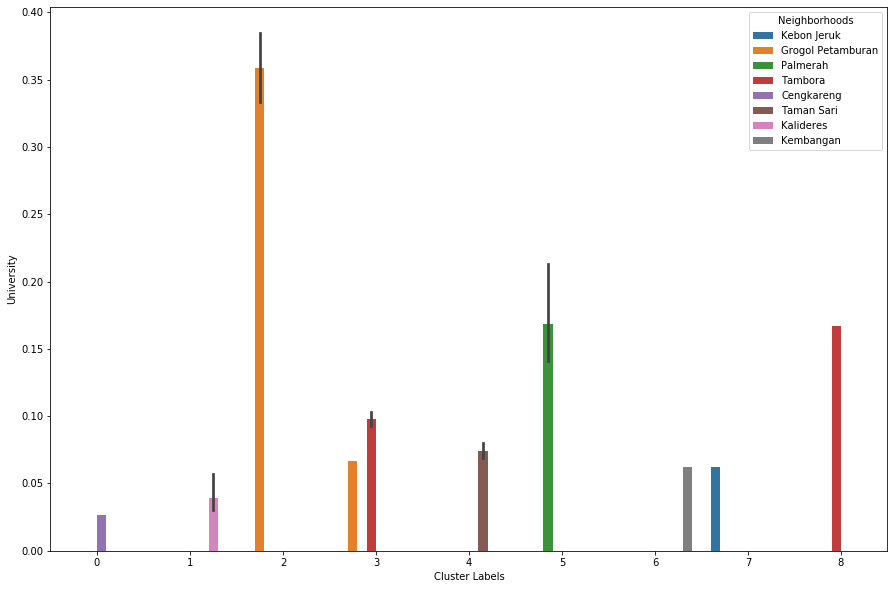

In [209]:
plt.figure(figsize=(15,10))
plt.show(sns.barplot(x='Cluster Labels', y='University', data=wj_merged_final, hue='Neighborhoods', ))

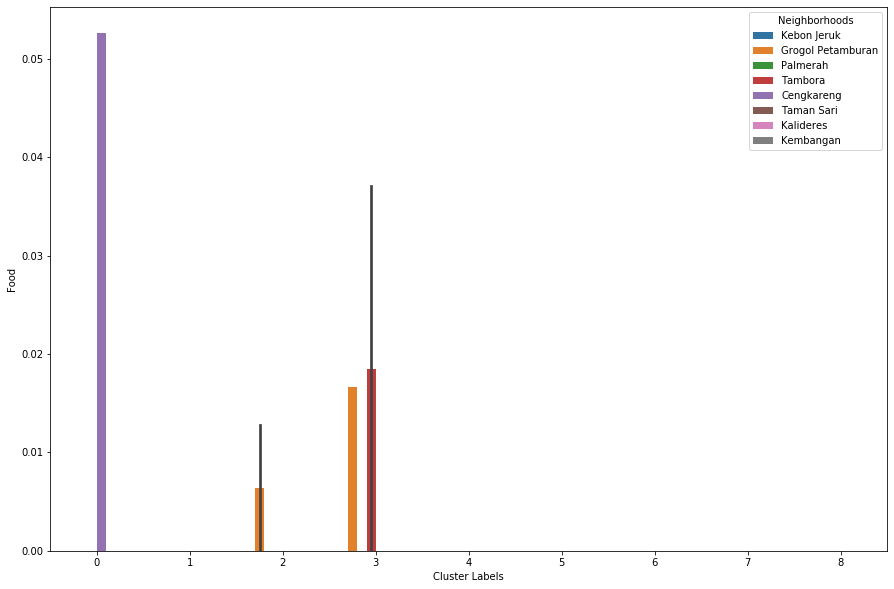

In [210]:
plt.figure(figsize=(15,10))
plt.show(sns.barplot(x='Cluster Labels', y='Food', data=wj_merged_final, hue='Neighborhoods'))

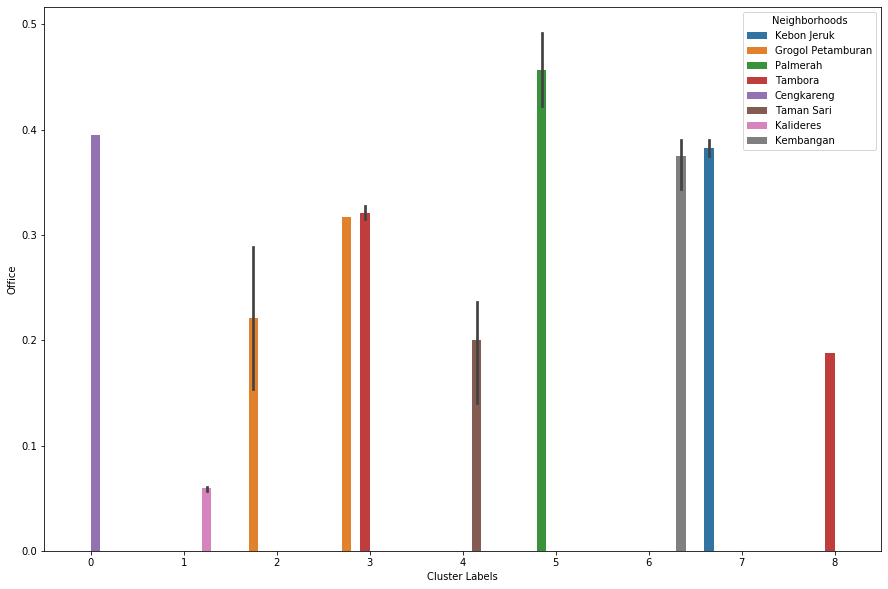

In [211]:
plt.figure(figsize=(15,10))
plt.show(sns.barplot(x='Cluster Labels', y='Office', data=wj_merged_final, hue='Neighborhoods'))

## Result and Discussion

Based on our analysis above, we can build conclusions that will be useful to aid people who want visit the West Jakarta, Indonesia for living and continue their study at University, looking for job or all of it.

From visualization, we can see that environment around Cluster 3 more stable than another cluster. This cluster recomended for pepole who come to West Jakarta for continue their study, working and looking for some foods. The condition of Cluster 1, recomended for people who come to West Jakarta for looking for job and looking for some food. If people who come to West Jakarta only for continue their study, Cluster 2 can be considered. 

## Conclusion

The aim of this project is to explore the residence in West Jakarta that people choose to live and carry out their activities such as lecturing, eating and working. These residence have been identified using Foursquare and have been plotted on the map. The map reveals that there are three main areas can be choose: Cluster 3, Cluster 1 and Cluster 2. Based on their need, peopl can choose between three clusters.